In [1]:
# IMPORT PACKAGES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

# SET VARIABLES
PATH = 'F:/PGAIML/CapstoneProject_PneumoniaDetection-main/'
os.chdir(PATH)

DATA_DIR = os.path.join(PATH + 'data/')
TRAIN_IMAGES = os.path.join(DATA_DIR + 'stage_2_train_images/')
TEST_IMAGES = os.path.join(DATA_DIR + 'stage_2_test_images/')
OUTPUT_DIR = os.path.join(PATH + 'output/')

if not os.path.exists(DATA_DIR): os.makedirs(DATA_DIR)
# if not os.path.exists(TRAIN_IMAGES): os.makedirs(TRAIN_IMAGES)
# if not os.path.exists(TEST_IMAGES): os.makedirs(TEST_IMAGES)
if not os.path.exists(OUTPUT_DIR): os.makedirs(OUTPUT_DIR)

Exploratory Data Analysis (EDA)
Here as a part of EDA, we will:

Start with understanding of the data with a brief on train/test labels and respective class info
Look at the first five rows of both the csvs (train and test)
Identify how are classes and target distributed
Check the number of patients with 1, 2, ... bounding boxes
Read and extract metadata from dicom files
Perform analysis on some of the features from dicom files
Check some random images from the training dataset
Draw insights from the data at various stages of EDA

Reading CSVs
Images for the current stage in the stage_2_train_images and stage_2_test_images.
Training data: stage_2_train_labels.csv
stage_2_detailed_class_info.csv containing detailed information about the positive and negative classes in the training set

In [3]:
print('--'*15, 'Reading Datasets (two csv files)', '--'*15)
train_labels = pd.read_csv(DATA_DIR + 'stage_2_train_labels.csv')
class_info = pd.read_csv(DATA_DIR +'stage_2_detailed_class_info.csv')

print(f'Train Labels dataframe has {train_labels.shape[0]} rows and {train_labels.shape[1]} columns')
print(f'Class info dataframe has {class_info.shape[0]} rows and {class_info.shape[1]} columns')
print('Number of duplicates in patientID in train labels dataframe: {}'.format(len(train_labels) - (train_labels['patientId'].nunique())))
print('Number of duplicates in patientID in class info dataframe: {}'.format(len(class_info) - (class_info['patientId'].nunique())))

------------------------------ Reading Datasets (two csv files) ------------------------------
Train Labels dataframe has 30227 rows and 6 columns
Class info dataframe has 30227 rows and 2 columns
Number of duplicates in patientID in train labels dataframe: 3543
Number of duplicates in patientID in class info dataframe: 3543


In [4]:
print('--'*10, 'First five rows of both dataframes (train_labels, class_info)', '--'*10)
print('Train labels dataframe:\n'); display(train_labels.head())
print('\nClass info dataframe:\n'); display(class_info.head())

-------------------- First five rows of both dataframes (train_labels, class_info) --------------------
Train labels dataframe:



,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1



Class info dataframe:



,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [5]:
print('Numbers of nulls in bounding boxes columns are equal to the 0s we\'ve in Target column'); print('--'*40)
print('Checking nulls in bounding boxes columns: {}'.format(train_labels[['x', 'y', 'width', 'height']].isnull().sum().to_dict())) 
print('Checking value counts for the targets: {}'.format(train_labels['Target'].value_counts().to_dict()))

Numbers of nulls in bounding boxes columns are equal to the 0s we've in Target column
--------------------------------------------------------------------------------
Checking nulls in bounding boxes columns: {'x': 20672, 'y': 20672, 'width': 20672, 'height': 20672}
Checking value counts for the targets: {0: 20672, 1: 9555}


Lets check the distribution of `Target` and `class` column
--------------------------------------------------------------------------------


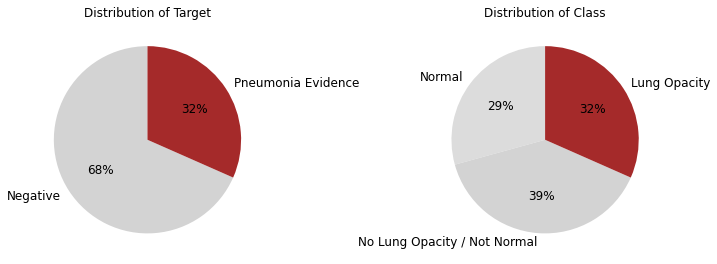

In [6]:
print('Lets check the distribution of `Target` and `class` column'); print('--'*40)
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(121)
g = (train_labels['Target'].value_counts()
    .plot(kind = 'pie', autopct = '%.0f%%', 
          labels = ['Negative', 'Pneumonia Evidence'], 
          colors = ['lightgray', 'brown'], 
          startangle = 90, 
          title = 'Distribution of Target', fontsize = 12)
    .set_ylabel(''))
ax = fig.add_subplot(122)
g = (class_info['class'].value_counts().sort_index(ascending = False)
    .plot(kind = 'pie', autopct = '%.0f%%', 
          colors = ['gainsboro', 'lightgray', 'brown'], 
          startangle = 90, title = 'Distribution of Class', 
          fontsize = 12)
    .set_ylabel(''))
plt.tight_layout()

In [7]:
print('Let\'s group by patient IDs and check number of bounding boxes for each unique patient ID');print('--'*40)
bboxes = train_labels.groupby('patientId').size().to_frame('number_of_boxes').reset_index()
train_labels = train_labels.merge(bboxes, on = 'patientId', how = 'left')
print('Number of unique patient IDs in the dataset: {}'.format(len(bboxes)))
print('\nNumber of patientIDs per bboxes in the dataset')
(bboxes.groupby('number_of_boxes')
.size()
.to_frame('number_of_patientIDs_per_boxes')
.reset_index()
.set_index('number_of_boxes')
.sort_values(by = 'number_of_boxes'))

Let's group by patient IDs and check number of bounding boxes for each unique patient ID
--------------------------------------------------------------------------------
Number of unique patient IDs in the dataset: 26684

Number of patientIDs per bboxes in the dataset


,number_of_patientIDs_per_boxes
number_of_boxes,
1,23286
2,3266
3,119
4,13


In [8]:
print('Let\'s also check whether each patientId has only one type of class'); print('--'*40)
print('Yes, each patientId is associated with only {} class'.format(class_info.groupby(['patientId'])['class'].nunique().max()))

# Merge the two dataframes
train_class = pd.concat([train_labels, class_info['class']], axis = 1)
print('Shape of the dataset after the merge: {}'.format(train_class.shape))

Let's also check whether each patientId has only one type of class
--------------------------------------------------------------------------------
Yes, each patientId is associated with only 1 class
Shape of the dataset after the merge: (30227, 8)


In [9]:
train_class.head()

,patientId,x,y,width,height,Target,number_of_boxes,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,1,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2,Lung Opacity


Observations from the CSVs
Based on analysis above, some of the observations:

Training data is having a set of patientIds and bounding boxes. Bounding boxes are defined as follows: x, y, width and height.
There are multiple records for patients. Number of duplicates in patientID = 3,543.
There is also a binary target column i.e. Target indicating there was evidence of pneumonia or no definitive evidence of pneumonia.
Class label contains: No Lung Opacity/Not Normal, Normal and Lung Opacity.
Chest examinations with Target = 1 i.e. ones with evidence of Pneumonia are associated with Lung Opacity class.
Chest examinations with Target = 0 i.e. those with no definitive effidence of Pneumonia are either of Normal or No Lung Opacity / Not Normal class.
About 23,286 patientIds (~87% of them) provided have 1 bounding boxes while 13 patients have 4 bounding boxes!!!!

Reading Images
Images provided are stored in DICOM (.dcm) format which is an international standard to transmit, store, retrieve, print, process, and display medical imaging information. Digital Imaging and Communications in Medicine (DICOM) makes medical imaging information interoperable. We will make use of pydicom package here to read the images.

In [10]:
import pydicom as dcm
sample_patient_id = train_labels['patientId'][0]
dcm_file = TRAIN_IMAGES + '{}.dcm'.format(sample_patient_id)
dcm_data = dcm.read_file(dcm_file)

print(dcm_data)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

Observations from dicom image files
From the above sample we can see that dicom file contains some of the information that can be used for further analysis such as sex, age, body part examined (which should be mostly chest), view position and modality. Size of this image is 1024 x 1024 (rows x columns).

Feature extraction from the dicom image files
Above we identified some features from the dicom files that can explored/used, let's focus on the following analysis from the image files

To understand distribution of age for those with evidence of lung opacity and those with no definite evidence of lung opacity.
To understand distribution of male and female for those with evidence of lung opacity and those with no definite evidence of lung opacity
Explore different view positions in the dataset
Explore modallity

To get the features from dicom image files, we will make use of function (get_tags).

In [11]:
# Helper function to plot the dicom images
def plot_dicom_images(data, df, img_path):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3, 3, figsize = (16, 18))
    for i, row in enumerate(img_data):
        image = row['patientId'] + '.dcm'
        path = os.path.join(img_path, image)
        data = dcm.read_file(path)
        rows = df[df['patientId'] == row['patientId']]
        age = rows.PatientAge.unique().tolist()[0]
        sex = data.PatientSex
        part = data.BodyPartExamined
        vp = data.ViewPosition
        modality = data.Modality
        data_img = dcm.dcmread(path)
        ax[i//3, i%3].imshow(data_img.pixel_array, cmap = plt.cm.bone)
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nAge: {}, Sex: {}, Part: {}, VP: {}, Modality: {}\nTarget: {}, Class: {}\nWindow: {}:{}:{}:{}'\
                              .format(row['patientId'], age, sex, part, 
                                      vp, modality, row['Target'], 
                                      row['class'], row['x'], 
                                      row['y'], row['width'],
                                      row['height']))
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy = (row['x'], row['y']),
                      width = row['width'], height = row['height'], 
                      color = 'blue', alpha = 0.15)) 
    plt.show()

In [12]:
# Helper function to get additional features from dicom images
def get_tags(data, path):
    images = os.listdir(path)
    for _, name in tqdm_notebook(enumerate(images)):
        img_path = os.path.join(path, name)
        img_data = dcm.read_file(img_path)
        idx = (data['patientId'] == img_data.PatientID)
        data.loc[idx,'PatientSex'] = img_data.PatientSex
        data.loc[idx,'PatientAge'] = pd.to_numeric(img_data.PatientAge)
        data.loc[idx,'BodyPartExamined'] = img_data.BodyPartExamined
        data.loc[idx,'ViewPosition'] = img_data.ViewPosition
        data.loc[idx,'Modality'] = img_data.Modality

In [13]:
# Helper function to plot bboxes scatter
# Reference for this function & plots: https://www.kaggle.com/gpreda/rsna-pneumonia-detection-eda
def bboxes_scatter(df1, df2, text1, text2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (13, 8))
    fig.subplots_adjust(top = 0.85)
    fig.suptitle('Plotting centers of lung opacity\n{} & {}'.format(text1, text2))
    df1.plot.scatter(x = 'xw', y = 'yh', ax = ax1, alpha = 0.8, marker = '.', 
                   xlim = (0, 1024), ylim = (0, 1024), color = 'green')
    ax1.set_title('Centers of Lung Opacity\n{}'.format(text1))
    for i, row in df1.iterrows():
        ax1.add_patch(Rectangle(xy = (row['x'], row['y']),
                            width = row['width'], height = row['height'], 
                            alpha = 3.5e-3, color = 'yellow'))
    plt.title('Centers of Lung Opacity\n{}'.format(text2))
    df2.plot.scatter(x = 'xw', y = 'yh', ax = ax2, alpha = 0.8, marker = '.',
                   color = 'brown',  xlim = (0, 1024), ylim = (0, 1024))
    ax2.set_title('Centers of Lung Opacity\n{}'.format(text2))
    for i, row in df2.iterrows():
        ax2.add_patch(Rectangle(xy = (row['x'], row['y']),
                             width = row['width'], height = row['height'],
                             alpha = 3.5e-3, 
                             color = 'yellow'))
    plt.show()

In [14]:
from glob import glob
print('Read the training images file names and path'); print('--'*40)
images = pd.DataFrame({'path': glob(os.path.join(TRAIN_IMAGES, '*.dcm'))})
images['patientId'] = images['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
print('Number of images in the training folder: {}'.format(images.shape[0]))
print('Columns in the training images dataframe: {}'.format(list(images.columns)))
assert images.shape[0] == len(list(set(train_class['patientId']))), 'Number of training images should be equal to the unique patientIds we have'

Read the training images file names and path
--------------------------------------------------------------------------------
Number of images in the training folder: 26684
Columns in the training images dataframe: ['path', 'patientId']


In [15]:
from tqdm import tqdm
print('Merge path from the `images` dataframe with `train_class` dataframe'); print('--'*40)
train_class = train_class.merge(images, on = 'patientId', how = 'left')
print('Shape of the `train_class` dataframe after merge: {}'.format(train_class.shape))

Merge path from the `images` dataframe with `train_class` dataframe
--------------------------------------------------------------------------------
Shape of the `train_class` dataframe after merge: (30227, 9)


In [17]:
from tqdm import tqdm_notebook
print('Get features such as {} from training images'.format(('PatientSex', 'PatientAge', 'BodyPartExamined', 'ViewPosition', 'Modality')))
get_tags(train_class, TRAIN_IMAGES)

print('Saving the feature engineered dataframe for future use'); print('--'*40)
train_class.to_pickle('./output/train_feature_engineered.pkl')

Get features such as ('PatientSex', 'PatientAge', 'BodyPartExamined', 'ViewPosition', 'Modality') from training images



Saving the feature engineered dataframe for future use
--------------------------------------------------------------------------------


In [18]:
train_class = pd.read_pickle('./output/train_feature_engineered.pkl')
train_class.shape

(30227, 14)

In [19]:
train_class.head()

,patientId,x,y,width,height,Target,number_of_boxes,class,path,PatientSex,PatientAge,BodyPartExamined,ViewPosition,Modality
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,F:/PGAIML/CapstoneProject_PneumoniaDetection-m...,F,51.0,CHEST,PA,CR
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,F:/PGAIML/CapstoneProject_PneumoniaDetection-m...,F,48.0,CHEST,PA,CR
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,F:/PGAIML/CapstoneProject_PneumoniaDetection-m...,M,19.0,CHEST,AP,CR
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,1,Normal,F:/PGAIML/CapstoneProject_PneumoniaDetection-m...,M,28.0,CHEST,PA,CR
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2,Lung Opacity,F:/PGAIML/CapstoneProject_PneumoniaDetection-m...,F,32.0,CHEST,AP,CR


In [20]:
print('As expected unique in `BodyPartExamined` is: {}'.format(train_class['BodyPartExamined'].unique()[0]))
print('Unique in `Modality` is: {}'.format(train_class['Modality'].unique()[0])); print('--'*40)

As expected unique in `BodyPartExamined` is: CHEST
Unique in `Modality` is: CR
--------------------------------------------------------------------------------


Understanding different View Positions
As seen below, two View Positions that are in the training dataset are AP (Anterior/Posterior) and PA (Posterior/Anterior). These type of X-rays are mostly used to obtain the front-view. Apart from front-view, a lateral image is usually taken to complement the front-view.

Posterior/Anterior (PA): In PA, X-Ray beam hits the posterior (back) part of the chest before the anterior (front) part. While obtaining the image patient is asked to stand with their chest against the film.
Anterior/Posterior (AP): Attimes it's not possible for radiographers to acquire a PA chest X-ray. This is usually because the patient is too unwell to stand. AP projection images are of lower quality than PA images. Heart size is exaggerated (cardiothoracic ratio approximately 50%) [1].

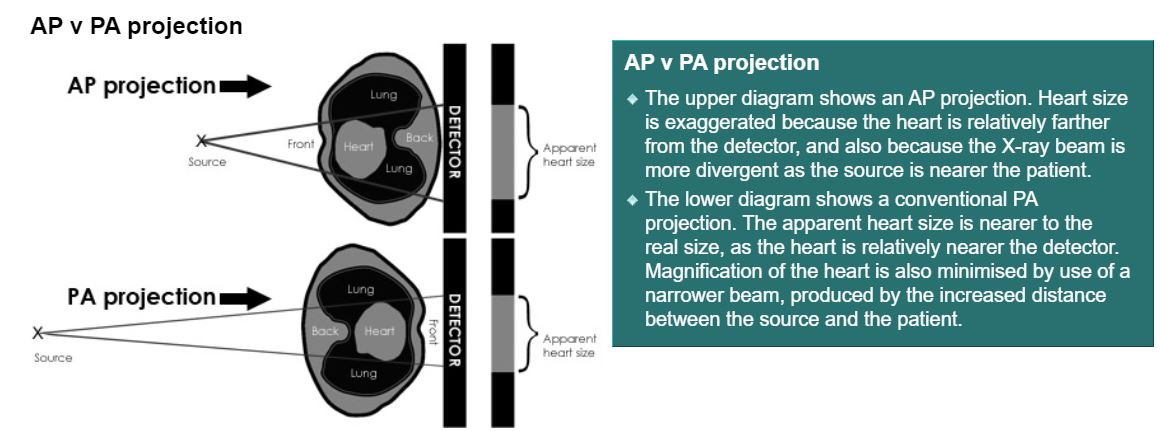

Get the distribution of `ViewPosition` overall and where Target = 1
Overall the distribution is almost equal for `ViewPosition` but where there's a Pneumonia Evidence, `ViewPosition` is `AP`
AP: Anterior/Posterior, PA: Posterior/Anterior
--------------------------------------------------------------------------------


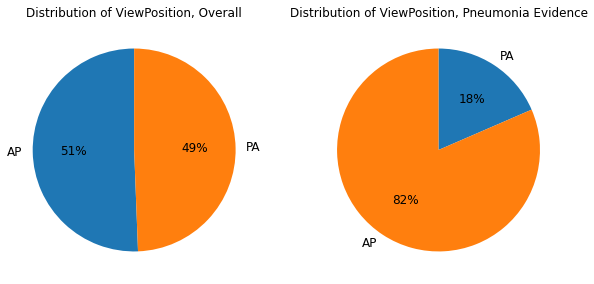

In [21]:
print('Get the distribution of `ViewPosition` overall and where Target = 1')
print('Overall the distribution is almost equal for `ViewPosition` but where there\'s a Pneumonia Evidence, `ViewPosition` is `AP`')
print('AP: Anterior/Posterior, PA: Posterior/Anterior'); print('--'*40)
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(121)
g = (train_class['ViewPosition'].value_counts()
    .plot(kind = 'pie', autopct = '%.0f%%',  
          startangle = 90,
          title = 'Distribution of ViewPosition, Overall', 
          fontsize = 12)
    .set_ylabel(''))
ax = fig.add_subplot(122)
g = (train_class.loc[train_class['Target'] == 1, 'ViewPosition']
     .value_counts().sort_index(ascending = False)
    .plot(kind = 'pie', autopct = '%.0f%%', 
          startangle = 90, counterclock = False, 
          title = 'Distribution of ViewPosition, Pneumonia Evidence', 
          fontsize = 12)
    .set_ylabel(''))

Exploring the bounding boxes for both view positions

Centers of the rectangle would be x+width/2 and y+height/2 as also described in the reference link (source).
We will make use of (bboxes_scatter) function in the (eda). Reference for these plots and function (source).

Plot x and y centers of bounding boxes
--------------------------------------------------------------------------------


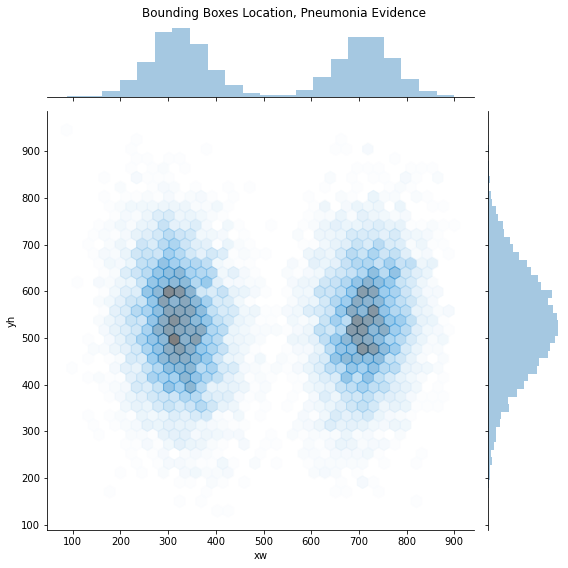

In [23]:
import seaborn as sns
print('Plot x and y centers of bounding boxes'); print('--'*40)
# Creating a dataframe with columns for center of the rectangles
bboxes = train_class[train_class['Target'] == 1]
bboxes['xw'] = bboxes['x'] + bboxes['width'] / 2
bboxes['yh'] = bboxes['y'] + bboxes['height'] / 2

g = sns.jointplot(x = bboxes['xw'], y = bboxes['yh'], data = bboxes, 
                  kind = 'hex', alpha = 0.5, size = 8)
plt.suptitle('Bounding Boxes Location, Pneumonia Evidence')
plt.tight_layout()
plt.subplots_adjust(top = 0.95)
plt.show()

Exploring the bounding boxes centers for `ViewPositions` for random sample = 1000


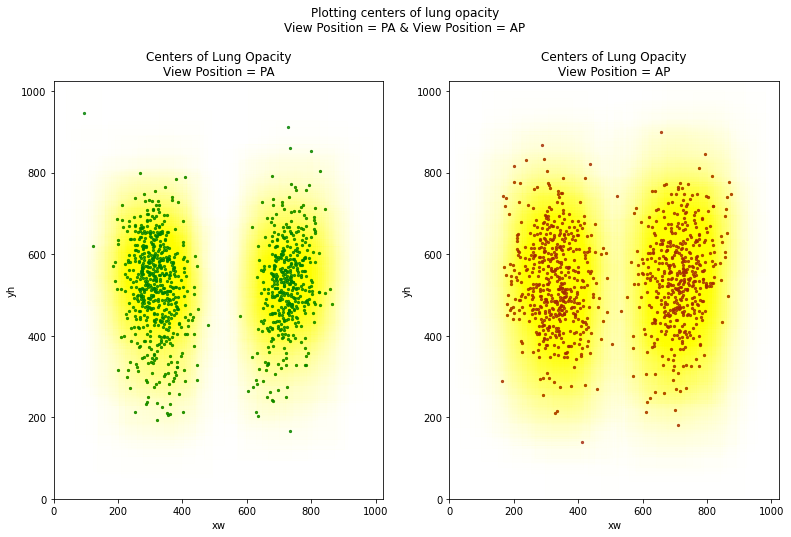

In [24]:
print('Exploring the bounding boxes centers for `ViewPositions` for random sample = 1000')

df1 = bboxes[bboxes['ViewPosition'] == 'PA'].sample(1000)
df2 = bboxes[bboxes['ViewPosition'] == 'AP'].sample(1000)
bboxes_scatter(df1, df2, 'View Position = PA', 'View Position = AP')

Observations: BodyPartExamined & ViewPosition
Above we saw,

BodyPartExamined is unique for all cases and is CHEST in the training dataset and that was also expected.
Unique in Modality is CR i.e. Computer Radiography
Overall ViewPosition is almost equally distributed in the training dataset but for cases where Target=1, most of the view position are AP.

Checking outliers in `PatientAge
--------------------------------------------------------------------------------
Minimum `PatientAge` in the training dataset: 1.0
Maximum `PatientAge` in the training dataset: 155.0
75th Percentile of `PatientAge` in the training dataset: 59.0
`PatientAge` in upper whisker for box plot: 84.0



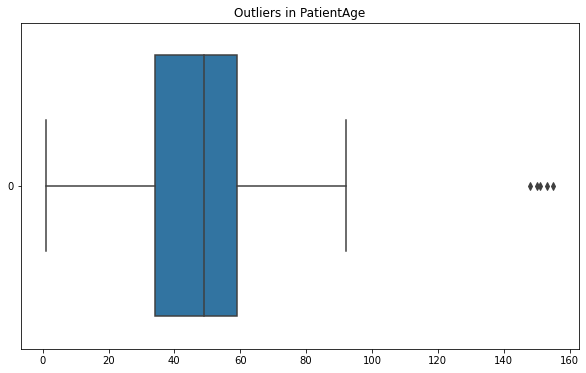

In [25]:
print('Checking outliers in `PatientAge'); print('--'*40)
print('Minimum `PatientAge` in the training dataset: {}'.format(train_class['PatientAge'].min()))
print('Maximum `PatientAge` in the training dataset: {}'.format(train_class['PatientAge'].max()))
print('75th Percentile of `PatientAge` in the training dataset: {}'.format(train_class['PatientAge'].quantile(0.75)))
print('`PatientAge` in upper whisker for box plot: {}'.format(train_class['PatientAge'].quantile(0.75) + (train_class['PatientAge'].quantile(0.75) - train_class['PatientAge'].quantile(0.25))))
print()
fig = plt.figure(figsize = (10, 6))
ax = sns.boxplot(data = train_class['PatientAge'], orient = 'h').set_title('Outliers in PatientAge')

We can make use of pd.clip() to trim value to a specified lower and upper threshold. So an upper threshold of 100 in PatientAge would mean those outlier values being converted to 100.

In [26]:
print('Using pd.clip to set upper threshold of 100 for age and remove outliers'); print('--'*40)
train_class['PatientAge'] = train_class['PatientAge'].clip(train_class['PatientAge'].min(), 100)
train_class['PatientAge'].describe().astype(int)

Using pd.clip to set upper threshold of 100 for age and remove outliers
--------------------------------------------------------------------------------


count    30227
mean        46
std         16
min          1
25%         34
50%         49
75%         59
max        100
Name: PatientAge, dtype: int32

Get the distribution of `PatientAge` overall and where Target = 1
--------------------------------------------------------------------------------


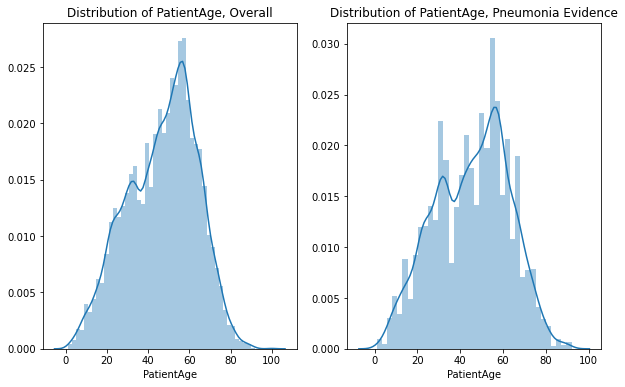

In [27]:
print('Get the distribution of `PatientAge` overall and where Target = 1'); print('--'*40)
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(121)
g = (sns.distplot(train_class['PatientAge'])
    .set_title('Distribution of PatientAge, Overall'))
ax = fig.add_subplot(122)
g = (sns.distplot(train_class.loc[train_class['Target'] == 1, 'PatientAge'])
    .set_title('Distribution of PatientAge, Pneumonia Evidence'))

Using Binning Method for PatientAge feature

We'll make use of a pd.cut which is 'Bin values into discrete intervals'. Use of this method is recommended when need is to segment and sort data values into bins. This function is also useful for going from a continuous variable to a categorical variable. Supports binning into an equal number of bins, or a pre-specified array of bins.

In [28]:
print('Creating Age Binning field', '--'*40)
train_class['AgeBins'] = pd.cut(train_class['PatientAge'], bins = 4, precision = 0, labels = ['<=26', '<=50', '<=75', '<=100'])
train_class['AgeBins'].value_counts()

Creating Age Binning field --------------------------------------------------------------------------------


<=75     13318
<=50     12157
<=26      3972
<=100      780
Name: AgeBins, dtype: int64

Value counts of the age bin field created
--------------------------------------------------------------------------------


,"Counts of Age Bins, Overall","Counts of Age Bins, Target=1"
<=26,3972,1478
<=50,12157,3917
<=75,13318,3895
<=100,780,265


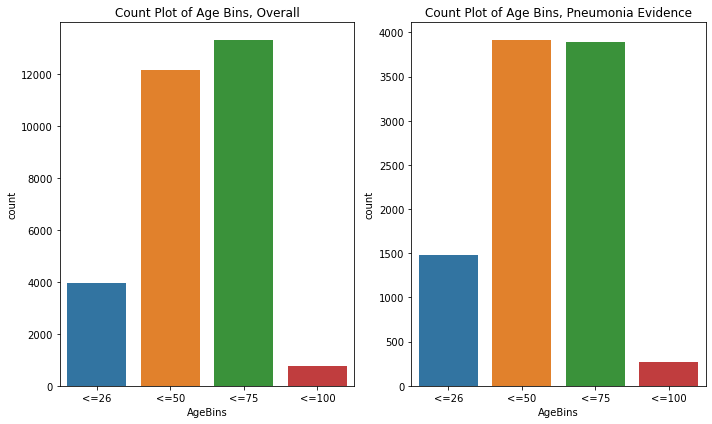

In [29]:
print('Value counts of the age bin field created'); print('--'*40)
display(pd.concat([train_class['AgeBins'].value_counts().sort_index().rename('Counts of Age Bins, Overall'), 
                   train_class.loc[train_class['Target'] == 1, 'AgeBins'].value_counts().sort_index().rename('Counts of Age Bins, Target=1')], axis = 1))
print()
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 6))
g = sns.countplot(x = train_class['AgeBins'], ax = ax1).set_title('Count Plot of Age Bins, Overall')
g = sns.countplot(x = train_class.loc[train_class['Target'] == 1, 'AgeBins'], ax = ax2).set_title('Count Plot of Age Bins, Pneumonia Evidence')
plt.tight_layout()

Exploring the bounding boxes centers for `AgeBins` for random sample = 200


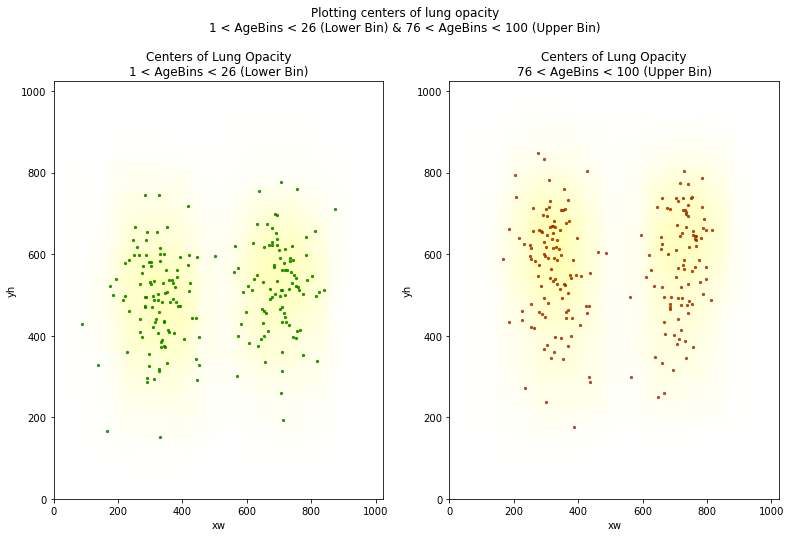

In [30]:
print('Exploring the bounding boxes centers for `AgeBins` for random sample = 200')
# Creating a dataframe with columns for center of the rectangles
bboxes = train_class[train_class['Target'] == 1]
bboxes['xw'] = bboxes['x'] + bboxes['width'] / 2
bboxes['yh'] = bboxes['y'] + bboxes['height'] / 2

df1 = bboxes[bboxes['AgeBins'] == '<=26'].sample(200)
df2 = bboxes[bboxes['AgeBins'] == '<=100'].sample(200)
bboxes_scatter(df1, df2, '1 < AgeBins < 26 (Lower Bin)', '76 < AgeBins < 100 (Upper Bin)')

Checking distribution of age for those with Pneumonia Evidence, by Gender & Count Plot of Gender
--------------------------------------------------------------------------------


,"% Gender, Overall","% Gender, Target=1"
F,0.43,0.42
M,0.57,0.58


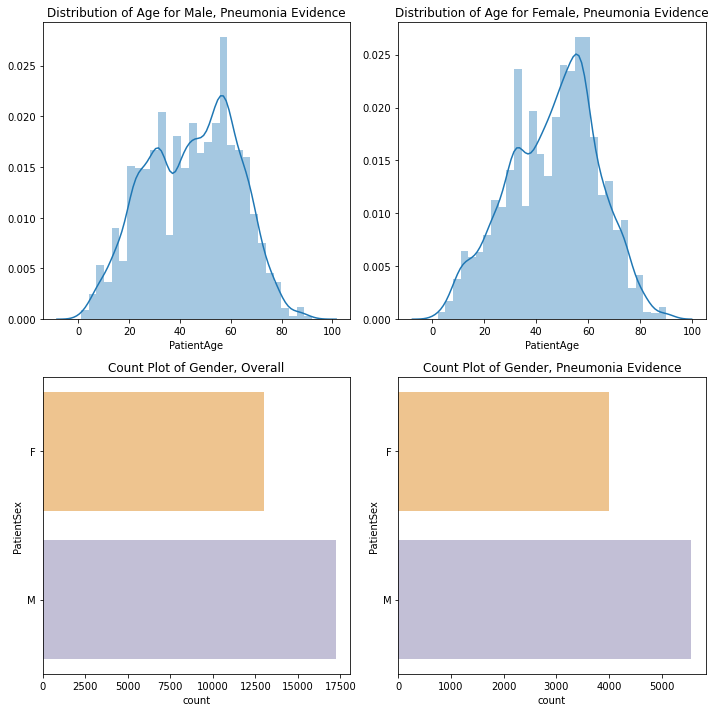

In [31]:
print('Checking distribution of age for those with Pneumonia Evidence, by Gender & Count Plot of Gender'); print('--'*40)
display(pd.concat([train_class['PatientSex'].value_counts(normalize = True).round(2).sort_values().rename('% Gender, Overall'), 
                   train_class.loc[(train_class['Target'] == 1), 'PatientSex']
                   .value_counts(normalize = True).round(2).sort_index().rename('% Gender, Target=1')], axis = 1))

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (10, 10))
g = sns.distplot(train_class.loc[(train_class['Target'] == 1) & (train_class['PatientSex'] == 'M'), 'PatientAge'], ax = ax1).set_title('Distribution of Age for Male, Pneumonia Evidence')
g = sns.distplot(train_class.loc[(train_class['Target'] == 1) & (train_class['PatientSex'] == 'F'), 'PatientAge'], ax = ax2).set_title('Distribution of Age for Female, Pneumonia Evidence')
g = sns.countplot(y = train_class['PatientSex'], ax = ax3, palette = 'PuOr').set_title('Count Plot of Gender, Overall')
g = sns.countplot(y = train_class.loc[(train_class['Target'] == 1), 'PatientSex'], ax = ax4, palette = 'PuOr').set_title('Count Plot of Gender, Pneumonia Evidence')
plt.tight_layout()

Exploring the bounding boxes centers for `PatientSex` for random sample = 1000


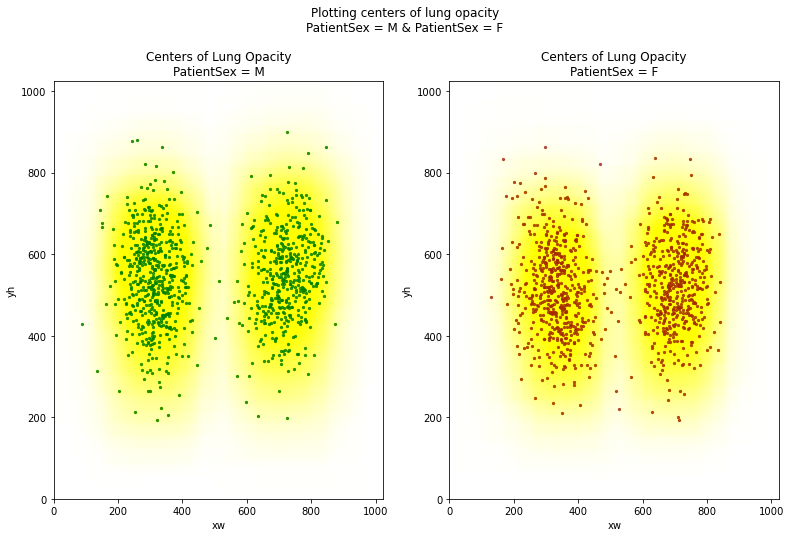

In [32]:
print('Exploring the bounding boxes centers for `PatientSex` for random sample = 1000')
df1 = bboxes[bboxes['PatientSex'] == 'M'].sample(1000)
df2 = bboxes[bboxes['PatientSex'] == 'F'].sample(1000)
bboxes_scatter(df1, df2, 'PatientSex = M', 'PatientSex = F')

Observations: PatientAge & PatientSex
Above we saw,

For PatientAge we saw the distribution for both overall and where there were evidence of Pneumonia. Used binning to check the count of age bins. Count was highest for age group 40-78 both overall and with Pneumonia Evidence.
Saw distribution of age for Male and Female with Pneumonia Evidence.
Dataset had more Males (57%-58%) than Females (42%-43%).
Only PatientAge, PatientSex and ViewPosition are useful features from metadata.

Dropping the other features from train_class dataframe and save that as a pickle file

In [33]:
train_class.drop(['BodyPartExamined', 'Modality', 'AgeBins'], inplace = True, axis = 1)
train_class.to_pickle('./output/train_class_features.pkl')
display(train_class.shape, train_class.head())

(30227, 12)

,patientId,x,y,width,height,Target,number_of_boxes,class,path,PatientSex,PatientAge,ViewPosition
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,F:/PGAIML/CapstoneProject_PneumoniaDetection-m...,F,51.0,PA
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,F:/PGAIML/CapstoneProject_PneumoniaDetection-m...,F,48.0,PA
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,F:/PGAIML/CapstoneProject_PneumoniaDetection-m...,M,19.0,AP
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,1,Normal,F:/PGAIML/CapstoneProject_PneumoniaDetection-m...,M,28.0,PA
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2,Lung Opacity,F:/PGAIML/CapstoneProject_PneumoniaDetection-m...,F,32.0,AP


Check some random samples from training data
Checking some random samples as below:

Different classes i.e. Normal, No Lung Opacity / Not Normal and Lung Opacity
Two view positions that we have in the dataset
For the one with Pneumonia Evidence and age = 92
Now, we will make use of custom module (eda) and function (plot_dicom_images) already imported earlier to visualize the images.

Checking sample for different classes


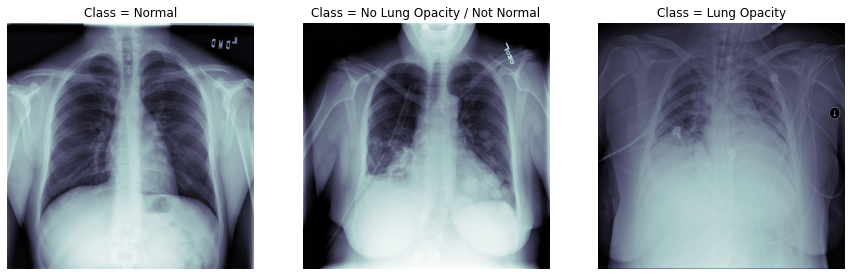

In [34]:
print('Checking sample for different classes')
sample1 = train_class.loc[train_class['class'] == 'Normal'].iloc[0]
sample2 = train_class.loc[train_class['class'] == 'No Lung Opacity / Not Normal'].iloc[0]
sample3 = train_class.loc[train_class['class'] == 'Lung Opacity'].iloc[1]
ds1 = dcm.dcmread(sample1['path'])
ds2 = dcm.dcmread(sample2['path'])
ds3 = dcm.dcmread(sample3['path'])

f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize = (15, 8))
ax1.imshow(ds1.pixel_array, cmap = plt.cm.bone)
ax1.set_title('Class = Normal')
ax1.axis('off')
ax2.imshow(ds2.pixel_array, cmap = plt.cm.bone)
ax2.set_title('Class = No Lung Opacity / Not Normal')
ax2.axis('off')
ax3.imshow(ds3.pixel_array, cmap = plt.cm.bone)
ax3.set_title('Class = Lung Opacity')
ax3.axis('off')
plt.show()

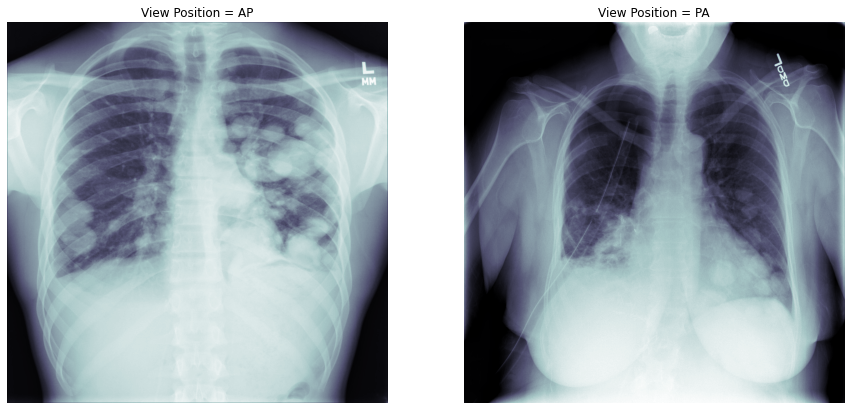

In [35]:
sample4 = train_class.loc[(train_class['ViewPosition'] == 'AP')].iloc[0]
sample5 = train_class.loc[(train_class['ViewPosition'] == 'PA')].iloc[0]
ds4 = dcm.dcmread(sample4['path'])
ds5 = dcm.dcmread(sample5['path'])

f, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (15, 8))
ax1.imshow(ds4.pixel_array, cmap = plt.cm.bone)
ax1.set_title('View Position = AP')
ax1.axis('off')
ax2.imshow(ds5.pixel_array, cmap = plt.cm.bone)
ax2.set_title('View Position = PA')
ax2.axis('off')
plt.show()

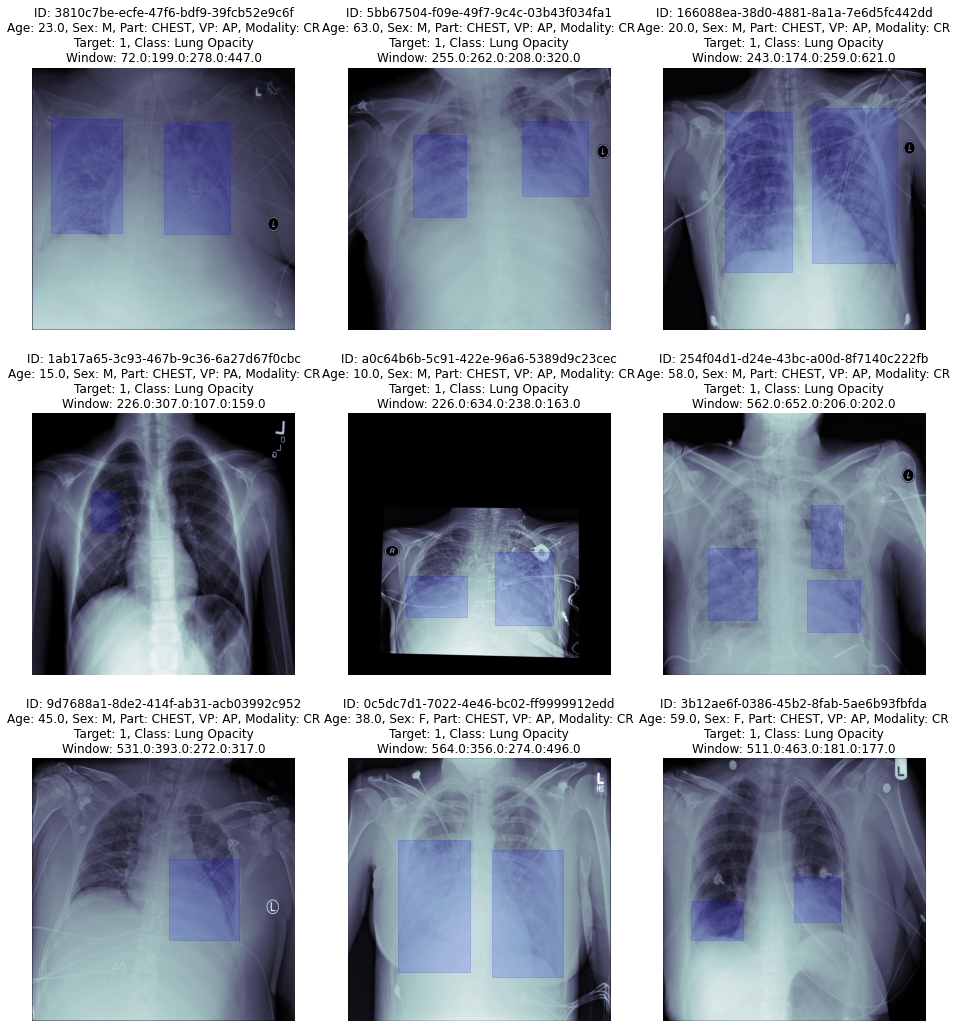

In [36]:
# this function is a part of custom module imported earlier (`eda`)
plot_dicom_images(data = train_class.loc[(train_class['Target'] == 1)].sample(9), 
                  df = train_class, img_path = TRAIN_IMAGES)

## Data Preparation

Split into Train & Valid
Splitting the list of training images in train and valid images
Random shuffle the list of training images

In [38]:
import random
print('Create training and valid sets. Contains list of filenames'); print('--'*40)
image_fns = os.listdir(TRAIN_IMAGES)
random.shuffle(image_fns)
val_size = round(len(image_fns)/10)
train_size = len(image_fns) - val_size

image_fns_train = image_fns[:train_size]
image_fns_val = image_fns[train_size: (train_size + val_size)]

print('Number of training samples: {}'.format(train_size))
print('Number of valid samples: {}'.format(val_size))

Create training and valid sets. Contains list of filenames
--------------------------------------------------------------------------------
Number of training samples: 24016
Number of valid samples: 2668


## Read Data & Prep for Model

Read a pickle file that was saved as part of EDA & Data Prep

In [41]:
# Read `train_class_features.pkl` file, saved as EDA & Data Prep Module
train_class = pd.read_pickle(OUTPUT_DIR + 'train_class_features.pkl')
display(train_class.shape, train_class.head())

(30227, 12)

,patientId,x,y,width,height,Target,number_of_boxes,class,path,PatientSex,PatientAge,ViewPosition
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,F:/PGAIML/CapstoneProject_PneumoniaDetection-m...,F,51.0,PA
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,F:/PGAIML/CapstoneProject_PneumoniaDetection-m...,F,48.0,PA
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,F:/PGAIML/CapstoneProject_PneumoniaDetection-m...,M,19.0,AP
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,1,Normal,F:/PGAIML/CapstoneProject_PneumoniaDetection-m...,M,28.0,PA
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2,Lung Opacity,F:/PGAIML/CapstoneProject_PneumoniaDetection-m...,F,32.0,AP


In [42]:
# A dataframe with paths, classes and targets
print('Prepare a dataframe with paths, classes and targets'); print('--'*40)
path_class_target = train_class[['patientId', 'path', 'class', 'Target']].copy(deep = True)
path_class_target['path'] = (path_class_target['path']
                             .str.replace('stage_2_train_images', 'stage_2_train_images_png')
                             .str.replace('.dcm', '.png'))
path_class_target.drop_duplicates(inplace = True)
display(path_class_target.shape, path_class_target.nunique())
print('\nDistribution of target and classes')
display(path_class_target['Target'].value_counts())
print()
display(path_class_target['class'].value_counts())

Prepare a dataframe with paths, classes and targets
--------------------------------------------------------------------------------


(26684, 4)

patientId    26684
path         26684
class            3
Target           2
dtype: int64


Distribution of target and classes


0    20672
1     6012
Name: Target, dtype: int64

No Lung Opacity / Not Normal    11821
Normal                           8851
Lung Opacity                     6012
Name: class, dtype: int64

In [44]:
# Run only if you haven't converted to png images yet
TRAIN_IMAGES_DIR = os.path.join(DATA_DIR + 'stage_2_train_images_png/')
print('Convert dicom to png images'); print('--'*40)

image_lists = [f for f in os.listdir(TRAIN_IMAGES)]
for f in tqdm_notebook(image_lists): 
    ds = dcm.read_file(TRAIN_IMAGES + f)
    img = ds.pixel_array
    cv2.imwrite(TRAIN_IMAGES_DIR + f.replace('.dcm','.png'), img)

Convert dicom to png images
--------------------------------------------------------------------------------


In [45]:
# Split the data in train, valid and test sets
print('Split the data in train, valid and test sets'); print('--'*40)

image_list = list(path_class_target['path'])
random.shuffle(image_list)
val_size = round(len(image_list)/10)
test_size = round(len(image_list)/10)
train_size = len(image_list)-test_size-val_size

X_train = image_list[:train_size]
X_valid = image_list[train_size:(train_size + val_size)]
X_test = image_list[(train_size + val_size):]

Split the data in train, valid and test sets
--------------------------------------------------------------------------------


In [46]:
print('Create Training, Validation and Test Dataframe with Path and Target'); print('--'*40)

df_train = (path_class_target.merge(pd.Series(X_train, name = 'path'), 
                                    on = 'path', 
                                    how = 'right')
          .drop(['class'], axis = 1))

df_valid = (path_class_target.merge(pd.Series(X_valid, name = 'path'), 
                                    on = 'path', 
                                    how = 'right')
          .drop(['class'], axis = 1))

df_test = (path_class_target.merge(pd.Series(X_test, name = 'path'), 
                                    on = 'path', 
                                    how = 'right')
          .drop(['class'], axis = 1))

print('Shape of the dataframes:\nTRAIN:{}\nVALID:{}\nTEST:{}'.format(df_train.shape, df_valid.shape, df_test.shape))

Create Training, Validation and Test Dataframe with Path and Target
--------------------------------------------------------------------------------
Shape of the dataframes:
TRAIN:(21348, 3)
VALID:(2668, 3)
TEST:(2668, 3)


In [47]:
print('Training, Validation and Test set is ~equally distributed on target'); print('--'*40)
print('Distribution of target in the training set:'); 
display(pd.Series(df_train['Target']).value_counts(normalize = True).round(2))
print('\nDistribution of target in the validation set:'); 
display(pd.Series(df_valid['Target']).value_counts(normalize = True).round(2))
print('\nDistribution of target in the test set:'); 
display(pd.Series(df_test['Target']).value_counts(normalize = True).round(2))

Training, Validation and Test set is ~equally distributed on target
--------------------------------------------------------------------------------
Distribution of target in the training set:


0    0.77
1    0.23
Name: Target, dtype: float64


Distribution of target in the validation set:


0    0.78
1    0.22
Name: Target, dtype: float64


Distribution of target in the test set:


0    0.77
1    0.23
Name: Target, dtype: float64

In [48]:
print('Save the train, valid and test dataframes for future use');print('--'*40)
df_train.to_pickle(OUTPUT_DIR + 'train_data.pkl')
df_valid.to_pickle(OUTPUT_DIR + 'valid_data.pkl')
df_test.to_pickle(OUTPUT_DIR + 'test_data.pkl')

Save the train, valid and test dataframes for future use
--------------------------------------------------------------------------------


In [51]:
# MODEL IMPORTS
import tensorflow as tf
assert tf.__version__ >= '2.0'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
#from skimage.transform import resize

import pydicom as dcm, cv2
from PIL import Image
import pandas as pd
import numpy as np
import keras
import math
random_state = 2020

# ROC AUC as a Metric
# Reference: https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
def roc_auc(y_true, y_pred):
    return tf.compat.v1.py_function(roc_auc_score, (y_true, y_pred), tf.double)

# Average Precision as a Metric
import tensorflow.keras.backend as K
def average_precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# F1 score as a Metric
# Reference: https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Data generator
class DataGenerators:
    def __init__(self, df_train, df_valid, df_test, batch_size, path,
                 img_size = (224, 224), class_mode = 'binary',
                 random_state = 2020):
        self.df_train = df_train
        self.df_valid = df_valid
        self.df_test = df_test
        self.batch_size = batch_size
        self.img_size = img_size
        self.path = path
        self.class_mode = class_mode
        
        train_augmenter = ImageDataGenerator(
            preprocessing_function = preprocess_input,
            rotation_range = 20, width_shift_range = 0.2,
            height_shift_range = 0.2, zoom_range = 0.2,
            horizontal_flip = True, rescale = 1/255.
            )
        
        valid_augmenter = ImageDataGenerator(
            preprocessing_function = preprocess_input, 
            rescale = 1/255.
            )
        
        test_augmenter = ImageDataGenerator(
            preprocessing_function = preprocess_input,
            rescale = 1/255.
            )
        
        print('Train Generator Created', '--'*20)
        self.train_generator = train_augmenter.flow_from_dataframe(
            x_col = 'path',
            y_col = 'Target',
            dataframe = self.df_train,
            batch_size = self.batch_size,
            target_size = self.img_size,
            directory = self.path,
            class_mode = self.class_mode,
            seed = random_state,
            shuffle = True
            )
        print('Validation Generator Created', '--'*20)
        self.valid_generator = valid_augmenter.flow_from_dataframe(
            x_col = 'path',
            y_col = 'Target',
            dataframe = self.df_valid,
            batch_size = self.batch_size,
            target_size = self.img_size,
            directory = self.path,
            class_mode = self.class_mode,
            seed = random_state,
            shuffle = False
            )
        print('Test Generator Created', '--'*20)
        self.test_generator = test_augmenter.flow_from_dataframe(
            x_col = 'path',
            y_col = 'Target',
            dataframe = self.df_test,
            batch_size = self.batch_size,
            target_size = self.img_size,
            directory = self.path,
            class_mode = self.class_mode,
            seed = random_state,
            shuffle = False
            )
        
        self.step_size_train = math.ceil(
            self.train_generator.n//self.train_generator.batch_size + 1
            )
        self.step_size_valid = math.ceil(
            self.valid_generator.n//self.valid_generator.batch_size + 1
            )
        self.step_size_test = math.ceil(
            self.test_generator.n//self.test_generator.batch_size + 1
            )

Using TensorFlow backend.


In [52]:
# USE GPU FOR MODEL TRAINING
config = tf.compat.v1.ConfigProto(log_device_placement = True, allow_soft_placement = True)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config = config)
list_gpu = tf.config.experimental.list_physical_devices(device_type = 'GPU')
if len(list_gpu)==1: strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
else: strategy = tf.distribute.MirroredStrategy()
print('Num GPUs Available: ', len(list_gpu))
tf.config.optimizer.set_experimental_options({'auto_mixed_precision': True})
print('Mixed precision enabled')

Device mapping:

Num GPUs Available:  0
Mixed precision enabled


## Model - DenseNet121

In [53]:
# Model Parameters
BATCH_SIZE = 32
IMAGE_SIZE = 224
EPOCH = 10
LEARNING_RATE = 1e-4
MONITOR = 'val_loss'
MODE = 'min'
VERBOSE = 1
FACTOR = 0.1
PATIENCE = 5
COOLDOWN = 5
BEST_MODEL = 'best_densenet.h5'
FINAL_MODEL = 'best_densenet_final.h5'
LOG_FILE = 'logs.csv'
LOSS = 'binary_crossentropy'
METRICS = ['accuracy', average_precision, f1_score]

In [54]:
df_train['Target'] = df_train['Target'].astype(str); 
df_valid['Target'] = df_valid['Target'].astype(str); 
df_test['Target'] = df_test['Target'].astype(str)

In [55]:
print('Create generators for training, validation and test dataframes'); print('--'*40)
generators = DataGenerators(df_train, df_valid, df_test, 
                            batch_size = BATCH_SIZE, 
                            path = TRAIN_IMAGES_DIR, 
                            img_size = (IMAGE_SIZE, IMAGE_SIZE), 
                            class_mode = 'binary',
                            random_state = random_state)

Create generators for training, validation and test dataframes
--------------------------------------------------------------------------------
Train Generator Created ----------------------------------------
Found 21348 validated image filenames belonging to 2 classes.
Validation Generator Created ----------------------------------------
Found 2668 validated image filenames belonging to 2 classes.
Test Generator Created ----------------------------------------
Found 2668 validated image filenames belonging to 2 classes.


In [56]:
def build_model():
    print('Create a `DenseNet121` model'); print('--'*40)
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
    inputs = Input(shape = input_shape)
    initializer = tf.keras.initializers.GlorotNormal()
    
    base_model = DenseNet121(include_top = False, input_tensor = inputs, weights ='imagenet')
    
    densenet = Model(inputs = inputs, outputs = base_model.layers[-1].output, name = 'DenseNet121')
    
    model = Sequential(name = 'DenseNet121')
    model.add(densenet)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'sigmoid', kernel_initializer = initializer))
    model.summary()
    return model

def callbacks():
    lrscheduler = ReduceLROnPlateau(monitor = MONITOR, factor = FACTOR, 
                                    patience = PATIENCE, verbose = VERBOSE, 
                                    mode = MODE, cooldown = COOLDOWN)
    
    model.compile(optimizer = Adam(lr = LEARNING_RATE), loss = LOSS, metrics = METRICS)
    
    cp = ModelCheckpoint(filepath = MODEL_WEIGHTS + BEST_MODEL, monitor = MONITOR, 
                         verbose = VERBOSE, save_best_only = True, mode = MODE)
    
    if os.path.exists(MODEL_WEIGHTS + LOG_FILE): os.remove(MODEL_WEIGHTS + LOG_FILE)
    csv_logger = CSVLogger(MODEL_WEIGHTS + LOG_FILE, append = True)
    
    callbacks = [cp, csv_logger, lrscheduler]
    return callbacks

In [59]:
MODEL_WEIGHTS = os.path.join(PATH + 'model_weights/')
if not os.path.exists(TRAIN_IMAGES_DIR): os.makedirs(TRAIN_IMAGES_DIR)
if not os.path.exists(MODEL_WEIGHTS): os.makedirs(MODEL_WEIGHTS)

In [ ]:
print('Lets fit the model.....')
K.clear_session()
with strategy.scope():
    model = build_model()
    callbacks = callbacks()
    train_generator = generators.train_generator
    validation_generator = generators.valid_generator
    test_generator = generators.test_generator    
    history = model.fit_generator(generator = train_generator, 
                                  steps_per_epoch = generators.step_size_train,
                                  epochs = EPOCH, verbose = VERBOSE, 
                                  callbacks = callbacks,
                                  validation_data = validation_generator, 
                                  validation_steps = generators.step_size_valid)
    print('Save the final weights'); print('--'*40)
    model.save(MODEL_WEIGHTS + FINAL_MODEL)

Lets fit the model.....
Create a `DenseNet121` model
--------------------------------------------------------------------------------
Model: "DenseNet121"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
DenseNet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________
Train for 668 steps, validate for 84 steps
Epoch 1/10
667/668 [============================>.] - ETA: 22